In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set()

In [2]:
random_seed = 17

In [ ]:
X, Y = get_data(True_positive="L1+Alu", True_negative="Random from genome")

In [76]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=random_seed, test_size=0.3)

In [77]:
y_train.mean(), y_test.mean()

(0.49557315936626284, 0.5103260869565217)

In [ ]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=300)
folded_data = model_selection.KFold(n_splits=5)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i = 0

for k, (train, test) in enumerate(folded_data.split(dfX, dfY)):
    probas_ = rf.fit(dfX.iloc[train], dfY.iloc[train]).predict_proba(dfX.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(dfY.iloc[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(
        fpr,
        tpr,
        lw=1,
        alpha=0.3,
        label='ROC fold %d (AUC = %0.2f)' % (k, roc_auc)
    )

plt.plot(
    [0, 1],
    [0, 1],
    linestyle='--',
    lw=2,
    color='r',
    label='Luck',
    alpha=.8
)
fpr, tpr, thresholds = roc_curve(dfY.iloc[test], probas_[:, 1])

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color='grey',
    alpha=.2,
    label=r'$\pm$ 1 std. dev.'
)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for transposon recognition')
plt.legend(loc="lower right")
plt.show()

In [ ]:
precisions = []
for k, (train, test) in enumerate(folded_data.split(dfX, dfY)):
    probas_ = rf.fit(dfX.iloc[train], dfY.iloc[train]).predict_proba(dfX.iloc[test])
    precision, recall, _ = precision_recall_curve(dfY.iloc[test], probas_[:, 1])
    precisions.append(average_precision_score(dfY.iloc[test], probas_[:, 1]))
    plt.step(
        recall,
        precision,
        alpha=0.5,
        where='post',
        label='Precision-recall fold {}'.format(k)
    )
average_precision = sum(precisions)/len(precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.legend(loc="lower right")
plt.show()

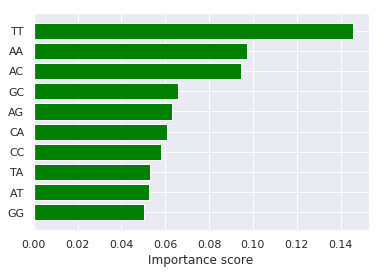

In [92]:
fig, ax = plt.subplots()

feature_importance = rf.feature_importances_.round(4)
feature_importance = zip(X.keys(), feature_importance)
feature_importance = np.array(sorted(list(feature_importance), key=lambda x:x[1], reverse=True))

y_pos = np.arange(10)

ax.barh(y_pos, fi_s[:10, 1].astype('float'), align='center', color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(feature_importance[:10, 0])
ax.invert_yaxis()
ax.set_xlabel('Importance score')

plt.show()

In [93]:
feature_importance = (rf.feature_importances_).round(4)
feature_importance = zip(X.keys(), feature_importance)
feature_importance = sorted(list(feature_importance), key=lambda x:x[1], reverse=True)
pd.DataFrame(feature_importance, columns=['Feature_name', 'Feature_importance']).head(10)

,Feature_name,Feature_importance
0,TT,0.1455
1,AA,0.0973
2,AC,0.0946
3,GC,0.0659
4,AG,0.0629
5,CA,0.0608
6,CC,0.0581
7,TA,0.0532
8,AT,0.0527
9,GG,0.0504
